# Sentiment and emotion analysis on LLY event

Sentiment analysis on the Eli Lilly free insulin event on 11 November 2022, with a dataset from Mastodon. Using sentiment scores determined by a imdb-trained bert and determining the vad scores with a emobank-trained bert. 

Written by Luc Bijl.

We define the date of the event.

In [1]:
import pandas as pd

date_of_event = pd.to_datetime('2022-11-10 18:36')

date_start = date_of_event - pd.Timedelta(days=2)
date_end =  date_of_event + pd.Timedelta(days=7)

## Emotion analysis of the topic: Lilly

Loading the Lilly topics dataset.

In [2]:
import pickle

with open('../datasets/bert-scored/lilly.pkl','rb') as file:
    df_lilly_raw = pickle.load(file)

df_lilly = df_lilly_raw[['Text', 'BERT sentiment score']].rename(columns={'BERT sentiment score': 'S'})

len(df_lilly)

104

Preparing the text for the network this includes tokenization, encoding and creating dataloaders.

In [3]:
import torch
from transformers import DistilBertTokenizerFast
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification

model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

lilly_encodings = tokenizer(df_lilly['Text'].tolist(), truncation=True, padding=True, return_tensors='pt')

lilly_dataset = torch.utils.data.TensorDataset(
    lilly_encodings['input_ids'], 
    lilly_encodings['attention_mask']
)
lilly_dataloader = DataLoader(lilly_dataset, batch_size=8, shuffle=False)

/home/luc/packages/anaconda/lib/python3.9/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Loading the model.

In [11]:
model = torch.load('bert-emobank.pth')

Using the model to perform emotion analysis on the dataset.

In [12]:
model.eval()
list_predicted_scores = {'V': [], 'A': [], 'D': []}

for batch in lilly_dataloader:
    with torch.no_grad():
        input_ids, attention_mask = batch

        # Obtaining the scores
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_scores = output.logits

        # Writing the scores to the list
        list_predicted_scores['V'].extend(predicted_scores[:, 0].tolist())
        list_predicted_scores['A'].extend(predicted_scores[:, 1].tolist())
        list_predicted_scores['D'].extend(predicted_scores[:, 2].tolist())

# Inserting the scores in df_lilly
for i in ['V', 'A', 'D']:
    df_lilly[i] = list_predicted_scores[i]

df_lilly.head(10)

,Text,S,V,A,D
Date,,,,,
2022-12-08 14:42:58,"ICYMI yesterday, our new cardiovascular report...",0.339886,0.175648,0.194201,0.217700
2022-12-05 17:58:35,skimgoth and water lillies?,0.025848,0.213328,0.174497,0.196348
2022-12-01 20:33:41,Sophia has nursery toys Charlie and Lilly for ...,0.354358,0.307794,0.221295,0.262469
2022-11-30 18:53:33,Eli Lilly CEO says insulin tweet flap “probabl...,-0.059616,0.153949,0.216449,0.206950
2022-11-28 03:01:05,Tickets acquired to see The Mountain Goats and...,0.588035,0.544307,0.455064,0.302969
2022-11-26 20:51:18,"""co-winner of the 1923 Nobel Prize for Physiol...",-0.083449,0.105105,0.239729,0.199464
2022-11-26 15:08:56,"excellent video (7 minutes, subtitled) by the ...",0.074707,0.215042,0.248881,0.222221
2022-11-25 00:53:04,Pretty easy to be thankful some days.,0.112512,0.322024,0.186560,0.223358
2022-11-23 11:55:28,Handling permissions in Android with all the e...,0.137852,0.237974,0.128814,0.226450


Evaluating the summary statistics.

In [13]:
df_lilly[['S', 'V', 'A', 'D']].describe()

,S,V,A,D
count,104.000000,104.000000,104.000000,104.000000
mean,-0.034357,0.168357,0.233780,0.228780
std,0.284442,0.100115,0.076152,0.028468
min,-0.701116,-0.077785,0.081932,0.172494
25%,-0.235667,0.104997,0.182599,0.209539
50%,-0.059021,0.177715,0.236129,0.228510
75%,0.182023,0.205968,0.272902,0.248508
max,0.588035,0.544307,0.562354,0.302969


Printing the most extreme sentences in the lilly dataset in either of the 4 dimensions.

In [14]:
for i in ['S', 'V', 'A', 'D']:
    print("Min {}:\n{}".format(i, df_lilly.iloc[df_lilly[i].argmin()]))
    print()
    print("Max {}:\n{}".format(i, df_lilly.iloc[df_lilly[i].argmax()]))
    print()
    print()

Min S:
Text    ‘More work to do’: Eli Lilly admits insulin pr...
S                                               -0.701116
V                                               -0.077785
A                                                 0.35421
D                                                0.208192
Name: 2022-11-19 19:43:11, dtype: object

Max S:
Text    Tickets acquired to see The Mountain Goats and...
S                                                0.588035
V                                                0.544307
A                                                0.455064
D                                                0.302969
Name: 2022-11-28 03:01:05, dtype: object


Min V:
Text    ‘More work to do’: Eli Lilly admits insulin pr...
S                                               -0.701116
V                                               -0.077785
A                                                 0.35421
D                                                0.208192
Name: 2022-11-19 19:43:1

Importing a seperate dataset.

In [29]:
import pandas as pd

date_of_event = pd.to_datetime('2022-11-10 18:36')
time_start = pd.to_datetime('2022-11-10 10:30:00')
time_end = pd.to_datetime('2022-11-12 15:30:00')

In [3]:
import_posts = '../../datasets/lly-case/svad-scored/lilly.csv'
df_posts = pd.read_csv(import_posts)
df_posts['date'] = pd.to_datetime(df_posts['date'])

df_posts_date = df_posts.set_index('date').sort_index()
len(df_posts_date)

104

Plotting the filtered mean of the sentiment, valence, arousal and dominance scores against the date.

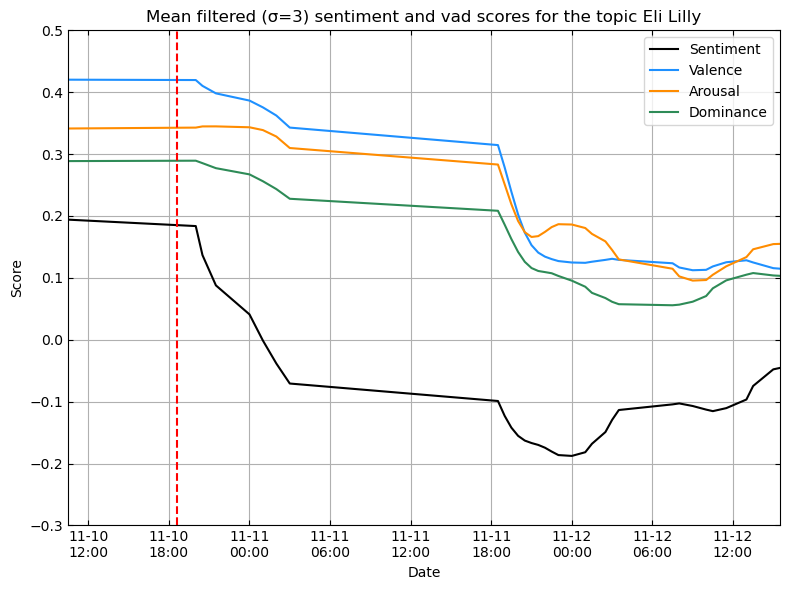

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from scipy.ndimage import gaussian_filter1d

resample_period = '30min'
sigma = 3

posts_resampled = {'s': [], 'v': [], 'a': [], 'd': []}
smoothed_scores = {'s': [], 'v': [], 'a': [], 'd': []}

for i in ['s', 'v', 'a', 'd']:
    posts_resampled[i] = df_posts_date[i].resample(resample_period).mean().dropna()
    smoothed_scores[i] = gaussian_filter1d(posts_resampled[i], sigma=sigma)
    

plt.figure(figsize=(10,6))

for i,j,k in zip(['s', 'v', 'a', 'd'], ['Sentiment', 'Valence', 'Arousal', 'Dominance'],['black', 'dodgerblue', 'darkorange', 'seagreen']):
    plt.plot(posts_resampled[i].index, smoothed_scores[i], label=j, color=k)

plt.ylim(-0.3, 0.5)
plt.xlim(time_start, time_end)

plt.title(f'Mean filtered (σ={sigma}) sentiment and vad scores for the topic Eli Lilly')
plt.xlabel('Date')
plt.ylabel('Score')
plt.grid(True)

plt.tick_params(axis='both', direction='in',top=True, right=True)
plt.axvline(date_of_event, color='red', linestyle='--')
plt.legend()

date_format = DateFormatter("%m-%d\n%H:%M")
plt.gca().xaxis.set_major_formatter(date_format)

plt.tight_layout()
plt.show()